<a href="https://colab.research.google.com/github/erezimm/ML-ML/blob/master/GNN_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main notebook, to be run on Google Colab

## Import dependencies and download datasets

In [1]:
!pip install dgl

from datetime import date
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from torch.utils.data import Dataset, DataLoader
import glob
import json
from tqdm.notebook import tqdm
import torch.optim as optim
import numpy as np
import networkx as nx
import astropy.io.ascii
import torch.nn as nn
import torch.nn.functional as F
from os.path import basename

import matplotlib.pyplot as plt

if not torch.cuda.is_available():
    raise Exception('Cuda unavailable, turn it on under Runtime>Change runtime type')
device = torch.device('cpu')

!wget -O data.zip https://github.com/erezimm/ML-ML/raw/master/data.zip
!unzip -o -q data.zip -d ./data
training_path = '/content/data/training_set'
validation_path = '/content/data/validation_set'

     |████████████████████████████████| 3.0MB 2.9MB/s 


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
--2020-08-05 17:03:15--  https://github.com/erezimm/ML-ML/raw/master/data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/erezimm/ML-ML/master/data.zip [following]
--2020-08-05 17:03:16--  https://raw.githubusercontent.com/erezimm/ML-ML/master/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59777 (58K) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  

## Create Datasets
Class CustomDataset loads all files and converts them to a list of graphs.
Each node in a graph is a data point, i.e. node features are days since start, mag, magerr

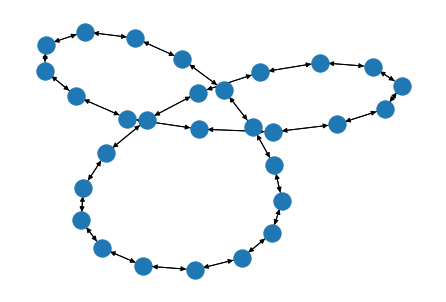

In [2]:
class CustomDataset(Dataset):
    def __init__(self, path):
        filelist = glob.glob(path+'/*')
        
        self.graphs = []
        self.isMicrolensed = []
        for fname in tqdm(filelist):
            filebasename = basename(fname)
            if filebasename.startswith('clean'):
                microlensed = torch.tensor([0])
            elif filebasename.startswith('microlensed'):
                microlensed = torch.tensor([1])
            else:
                raise Exception('Filename ' + fname + ' not clean_* or microlensed_*')
            
            with open(fname) as f:
                data = astropy.io.ascii.read(f.read())
                times, mags, magerrs = data['col1'], [], data['col3']
                for m, err in zip(data['col2'], magerrs):
                    mags.append(round(m, len(str(err).split('.')[1])))
                    # print(m, err, mags[-1])
                zipped = list(zip(times, mags, magerrs))
                zipped.sort(key=lambda tup: tup[0])
                times, mags, magerrs = zip(*zipped)

                n = len(times)
                g = dgl.DGLGraph()
                g.add_nodes(n)
                g.ndata['time'] = torch.tensor(times).float()  # days
                g.ndata['mag'] = torch.tensor(mags).float()
                g.ndata['magerr'] = torch.tensor(magerrs).float()
                g.add_edges([i for i in range(n)], [(i+1)%n for i in range(n)])
                g.add_edges([i for i in range(n)], [(i-1)%n for i in range(n)])
                
                self.graphs.append(g)
                self.isMicrolensed.append(microlensed)
        
    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], self.isMicrolensed[idx]


train_ds = CustomDataset(training_path)
# validation_ds = CustomDataset(validation_path)

nx.draw(dgl.to_networkx(train_ds[20][0]))

In [3]:
def collate(samples):
    # The input `samples` is a list, a batch of whatever comes out of your dataset object
    graphs = [x[0] for x in samples]
    labels = [x[1] for x in samples]
    
    batched_graph = dgl.batch(graphs, node_attrs=['time', 'mag', 'magerr'])
    targets = torch.cat(labels)
    
    return batched_graph, targets.unsqueeze(1).float()

## The Newtwork

In [4]:
n_ft = 3  # number of node features (time, mag, magerr)

class EdgeNetwork(nn.Module):
    def __init__(self, node_hidrep, edge_hidrep):
        super(EdgeNetwork, self).__init__()
        n_in = 2*(n_ft + node_hidrep)
        
        # params:
        sizes = [n_in] + [] + [edge_hidrep]  # edit middle list, can be empty

        # create networks:
        layers = []
        for i in range(len(sizes)-1):
            layers.extend([nn.Linear(sizes[i], sizes[i+1]), nn.ReLU()])
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        
        #your input x is an object with the following properties:
        # x.dst['node_features'], x.dst['node_hidden_state']
        # x.src['node_features'], x.src['node_hidden_state']
        # x.data['distance']
        
        #put them together with torch.cat

        # print( x.dst['time'].shape, x.dst['mag'].shape, x.dst['magerr'].shape, x.dst['node_hidrep'].shape,
        #         x.src['time'].shape, x.src['mag'].shape, x.src['magerr'].shape, x.src['node_hidrep'].shape )

        input = torch.cat(( x.dst['time'].unsqueeze(1), x.dst['mag'].unsqueeze(1), x.dst['magerr'].unsqueeze(1), x.dst['node_hidrep'],
                            x.src['time'].unsqueeze(1), x.src['mag'].unsqueeze(1), x.src['magerr'].unsqueeze(1), x.src['node_hidrep'] ), dim=1)
        
        #use a neural network to create an edge hidden represetation - 

        output = self.network(input)

        #you return a dictionary with what you want to "send" to the reciving node
        return {'edge_hidrep': output }

    
class NodeNetwork(nn.Module):
    def __init__(self, node_hidrep, edge_hidrep):
        super(NodeNetwork, self).__init__()
        n_in = edge_hidrep + node_hidrep + n_ft

        # params:
        sizes = [n_in] + [] + [node_hidrep]  # edit middle list, can be empty

        # create networks:
        layers = []
        for i in range(len(sizes)-1):
            layers.extend([nn.Linear(sizes[i], sizes[i+1]), nn.ReLU()])
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        
        #this time your input x has:
        # x.mailbox['edge hidden represetation'] -> this is what you send with the edge update function above - 
        # it will have the size of the node neighborhood - 
        # (Batch size, number of nodes in neighborhood, edge hidden rep size), so you need to sum/mean over dim=1 
        # x.data['node_hidden_state'] and x.data['node_features'] (this is the existing state of your node)
        # you need to torch.cat the message sum, node hidden state, and node features 
        #- and then apply some fully connected neural network
        
        mb = torch.mean( x.mailbox['edge_hidrep'] , dim=1 )

        input = torch.cat((mb, x.data['node_hidrep'], x.data['time'].unsqueeze(1), x.data['mag'].unsqueeze(1), x.data['magerr'].unsqueeze(1)), dim=1)
        out = self.network(input)

        # return a new hidden state for the node
        return {'node_hidrep': out }


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        # params:
        node_hidrep, edge_hidrep = 10, 10
        sizes_nodeinit = [n_ft] + [] + [node_hidrep]  # edit middle list, can be empty
        self.update_loop_length = 20
        self.sizes_finalnetwork = []

        # create networks:
        layers = []
        for i in range(len(sizes_nodeinit)-1):
            layers.extend([nn.Linear(sizes_nodeinit[i], sizes_nodeinit[i+1]), nn.ReLU()])
        self.node_init = nn.Sequential(*layers)
        self.edge_network = EdgeNetwork(node_hidrep, edge_hidrep)
        self.node_network = NodeNetwork(node_hidrep, edge_hidrep)
        
    def forward(self, g):
        features = torch.tensor(list(zip(g.ndata['time'], g.ndata['mag'], g.ndata['magerr'])))
        g.ndata['node_hidrep'] = self.node_init(features)
        for i in range(self.update_loop_length):
            g.update_all(self.edge_network, self.node_network)
        
        output = dgl.max_nodes(g, 'node_hidrep')
        output = torch.max(output, 1, keepdim=True)[0]
        # print(g.ndata['node_hidrep'].shape)
        # out = 0
        # for x in g.ndata['node_hidrep']:
        #     out = max(out, torch.sum(x))
        return output

In [5]:
net = Classifier()
net.to(device)

Classifier(
  (node_init): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=26, out_features=10, bias=True)
      (1): ReLU()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=23, out_features=10, bias=True)
      (1): ReLU()
    )
  )
)

## Train

In [6]:
loss_func = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [7]:
data_loader = DataLoader(train_ds, batch_size=30, shuffle=True, collate_fn=collate)

n_epochs = 50
for epoch in tqdm(range(n_epochs)):
    net.train()
    losses = []
    for x,y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = net(x)
        # print(output.shape, y.shape)
        loss = loss_func(output,y)
        losses.append(float(loss))
        loss.backward()
        optimizer.step()
    
    print(epoch, ':', np.mean(np.array(losses)))      

0 : 8186.0009765625
1 : 6917.5205078125
2 : 6287.2266845703125
3 : 5699.890625
4 : 5348.913269042969
5 : 4753.24072265625
6 : 4736.472106933594
7 : 4276.927795410156
8 : 4049.03173828125
9 : 3931.2927856445312
10 : 3722.8822021484375
11 : 3482.6061401367188
12 : 3179.6640014648438
13 : 2900.101318359375
14 : 2748.0017700195312
15 : 2512.9910278320312
16 : 2793.1351928710938
17 : 2338.277557373047
18 : 2356.189971923828
19 : 2140.305450439453
20 : 2067.9906616210938
21 : 1809.4600830078125
22 : 1690.0865783691406
23 : 1618.4025268554688
24 : 1591.7381439208984
25 : 1288.5643005371094
26 : 1168.0386199951172
27 : 1320.071029663086
28 : 1050.713607788086
29 : 879.6274871826172
30 : 960.8177032470703
31 : 790.1880493164062
32 : 730.7021484375
33 : 651.6477661132812
34 : 523.9306335449219
35 : 483.7599563598633
36 : 388.5619201660156
37 : 315.6547393798828
38 : 247.18789291381836
39 : 189.2827491760254
40 : 105.63350677490234
41 : 39.700239181518555
42 : 0.7998570054769516
43 : 0.6931474059

## Evaluate

Once you train your network you can evaluate on the test dataset, and compute the rate of false positive, false negative, etc,

train until you reach at least 60% true positive rate while maintaining a 90%+ true negative rate, and submit

In [8]:
test_data_loader = DataLoader(test_ds, batch_size=30, shuffle=True, collate_fn=collate)

net.cpu()
net.eval()

true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0
total_positives = 0
total_negatives = 0

for i, (x,y) in enumerate(test_data_loader):
        
        y = y.data.numpy()

        prediction = net(x).cpu().data.numpy()
        
        prediction[prediction >= 0.5] = 1
        prediction[prediction <0.5] = 0
        
        total_positives+=len(np.where( y==1 )[0])
        total_negatives+=len(np.where( y==0 )[0])
        
        true_positive+= len(np.where( (prediction==y) & (y==1) )[0])
        true_negative+= len(np.where( (prediction==y) & (y==0) )[0])
        false_positive+= len(np.where( (prediction!=y) & (y==0) )[0])
        false_negative+= len(np.where( (prediction!=y) & (y==1) )[0])
        
        
print('true positive: ', true_positive/total_positives)
print(false_negative/total_positives)
print('true negative: ', true_negative/total_negatives)
print(false_positive/total_negatives)

NameError: ignored

## Save
Don't forget to download

In [ ]:
torch.save(net.state_dict(), 'model.pt')